## Set up the environment

In [ ]:
 !pip install kaggle --upgrade
 

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c kkbox-churn-prediction-challenge

 98% 641M/654M [00:11<00:00, 53.3MB/s]
100% 654M/654M [00:11<00:00, 57.5MB/s]
  0% 0.00/6.88k [00:00<?, ?B/s]
100% 6.88k/6.88k [00:00<00:00, 7.26MB/s]
 97% 224M/231M [00:03<00:00, 75.9MB/s]
100% 231M/231M [00:03<00:00, 64.8MB/s]
 71% 33.0M/46.6M [00:00<00:00, 18.7MB/s]
100% 46.6M/46.6M [00:00<00:00, 50.6MB/s]
 66% 21.0M/32.0M [00:00<00:00, 19.8MB/s]
100% 32.0M/32.0M [00:00<00:00, 43.8MB/s]
 38% 12.0M/31.3M [00:00<00:01, 16.6MB/s]
100% 31.3M/31.3M [00:00<00:00, 53.3MB/s]
 45% 14.0M/31.3M [00:00<00:01, 14.1MB/s]
100% 31.3M/31.3M [00:00<00:00, 45.9MB/s]
100% 6.64G/6.65G [02:03<00:00, 64.5MB/s]
100% 6.65G/6.65G [02:03<00:00, 57.8MB/s]
 51% 15.0M/29.2M [00:00<00:01, 14.0MB/s]
100% 29.2M/29.2M [00:00<00:00, 42.8MB/s]
 99% 666M/675M [00:10<00:00, 67.4MB/s]
100% 675M/675M [00:10<00:00, 64.5MB/s]


In [ ]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 2.2MB/s 


In [ ]:
from pyunpack import Archive
Archive('train.csv.7z').extractall("/content/")
Archive('members_v3.csv.7z').extractall("/content/")
Archive('transactions.csv.7z').extractall("/content/")

In [ ]:
import pandas as pd
df_train = pd.read_csv('train.csv')
members = pd.read_csv('members_v3.csv')
transactions = pd.read_csv('transactions.csv')

In [ ]:
# 65 % - gender unknown. Drop - too many nulls
members.drop('gender', axis=1, inplace=True) 

In [ ]:
members

,msno,city,bd,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,9,20110915
...,...,...,...,...,...
6769468,VSGkb3hyBRUtb/b1MQUZbvOkktS3vKLnhMHW0CF8eyU=,1,0,7,20151020
6769469,nWjH7glPkZ7jOVaCRwwjlpmp0T1hSWdv8hMJxiWCwKc=,1,0,7,20151020
6769470,GH+b5+1tlv7ZZXsA8upBzVXMTLyffKcsF7WoU8b5rOI=,15,26,4,20151020
6769471,XVlwT3fdCFGKqerEKBzUIjK+jzI6jzSke4cDMVhYyjE=,1,0,4,20151020


In [ ]:
# Feature extarction
members['reg_month'] = members.registration_init_time.apply(lambda x : str(x)[-4:-2])
members['reg_year'] = members.registration_init_time.apply(lambda x : str(x)[:4])

In [ ]:
# We made use of it
members.drop('registration_init_time', axis=1, inplace=True)

In [ ]:
# Too many values to be informative
transactions.drop('payment_method_id', axis=1, inplace=True)

In [ ]:
# Adjust datatypes for memory efficiency
import numpy as np
def change_datatype(df):
    int_cols = list(df.select_dtypes(include=['int']).columns)
    for col in int_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)


def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)
        
change_datatype(members)
change_datatype_float(members)
# change_datatype(transactions)
# change_datatype_float(transactions)

In [ ]:
# Merge datasets
data = pd.merge(df_train, members, on='msno')

In [ ]:
del members

In [ ]:
# Feature engineering - general
transactions['discount'] = transactions['plan_list_price'] - transactions['actual_amount_paid']
transactions['is_discount'] = transactions.discount.apply(lambda x: 1 if x > 0 else 0)
transactions['price_per_day'] = transactions['actual_amount_paid'] / transactions['payment_plan_days']
transactions['membership_duration_left'] = transactions.membership_expire_date - transactions.transaction_date

In [ ]:
transactions['is_free_plan'] = (transactions.plan_list_price == 0).astype(int)

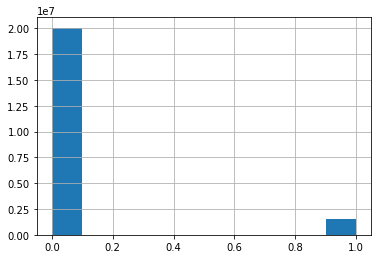

In [ ]:
# There are some users with a free plan
transactions['is_free_plan'].hist()

In [ ]:
# aggregate historical transactions
num_transactions = transactions.msno.value_counts()

In [ ]:
data = data.set_index('msno')

In [ ]:
# Merge aggregated features
data = data.join(num_transactions)
data = data.rename({'msno': 'num_transactions'}, axis=1)

In [ ]:
total_amount_paid = transactions.groupby('msno').sum().actual_amount_paid
data = data.join(total_amount_paid)
data = data.rename({'actual_amount_paid': 'total_amount_paid'}, axis=1)

In [ ]:
times_auto_renewed = transactions.groupby('msno').sum().is_auto_renew
data = data.join(times_auto_renewed)
data = data.rename({'is_auto_renew': 'times_auto_renew'}, axis=1)

In [ ]:
total_days = transactions.groupby('msno').sum().payment_plan_days
data = data.join(total_days)
data = data.rename({'payment_plan_days': 'total_days'}, axis=1)

In [ ]:
data

,is_churn,city,bd,registered_via,reg_month,reg_year,num_transactions,total_amount_paid,times_auto_renew,total_days,average_price_per_day
msno,,,,,,,,,,,
waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36,9,04,2005,2,149,0,37,4.966667
QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,9,04,2005,23,3458,22,663,109.819355
fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27,9,10,2005,10,1492,8,300,49.733333
mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23,9,11,2005,2,1788,0,820,4.360976
XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3,27,9,12,2005,8,3576,0,785,38.745591
...,...,...,...,...,...,...,...,...,...,...,...
AkluQxz947GHW4Y/kWWgocI04EjDNVQUZpes+5VmWek=,0,8,24,7,01,2017,2,258,2,60,8.600000
xC4Mahxw+X2H9E5gwE0Bb/c1NliMLT5yAca80U4Hck8=,0,1,0,7,01,2017,2,200,2,60,6.666667
tUM0yxAj50Vc35vQZ++xMlomdyeLJUW9lEcoPnt3H+g=,0,12,24,4,02,2017,2,298,2,60,9.933333


In [ ]:
average_price_per_day = transactions.replace(np.inf, 0).groupby('msno').sum().price_per_day
data = data.join(average_price_per_day)
data = data.rename({'price_per_day': 'average_price_per_day'}, axis=1)

In [ ]:
# Make use of the most recent transactions
last_transactions = transactions.sort_values('transaction_date').drop_duplicates('msno', keep = 'last')

In [ ]:
del transactions

In [ ]:
last_transactions.drop(['membership_expire_date', 'transaction_date'], axis=1, inplace=True)

In [ ]:
data = pd.merge(data, last_transactions, on='msno')

In [ ]:
data # Final data for modelling

,msno,is_churn,city,bd,registered_via,reg_month,reg_year,num_transactions,total_amount_paid,times_auto_renew,total_days,average_price_per_day,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,discount,is_discount,price_per_day,membership_duration_left,is_free_plan
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36,9,04,2005,2,149,0,37,4.966667,30,149,149,0,0,0,0,4.966667,99,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,9,04,2005,23,3458,22,663,109.819355,30,149,149,1,1,0,0,4.966667,97,0
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27,9,10,2005,10,1492,8,300,49.733333,30,149,149,1,1,0,0,4.966667,91,0
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23,9,11,2005,2,1788,0,820,4.360976,410,1788,1788,0,0,0,0,4.360976,10114,0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3,27,9,12,2005,8,3576,0,785,38.745591,30,149,149,0,0,0,0,4.966667,99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877156,AkluQxz947GHW4Y/kWWgocI04EjDNVQUZpes+5VmWek=,0,8,24,7,01,2017,2,258,2,60,8.600000,30,129,129,1,0,0,0,4.300000,103,0
877157,xC4Mahxw+X2H9E5gwE0Bb/c1NliMLT5yAca80U4Hck8=,0,1,0,7,01,2017,2,200,2,60,6.666667,30,100,100,1,0,0,0,3.333333,103,0
877158,tUM0yxAj50Vc35vQZ++xMlomdyeLJUW9lEcoPnt3H+g=,0,12,24,4,02,2017,2,298,2,60,9.933333,30,149,149,1,0,0,0,4.966667,103,0
877159,KQS8etmfGgvE/7Y9gK+E9wdLnRTI0lyyPXaXL3I8E4c=,0,15,17,4,02,2017,1,0,0,60,0.000000,60,0,0,0,0,0,0,0.000000,3,1


In [ ]:
data.drop(['city', 'bd'], axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
data.replace(np.inf, 0, inplace=True)
data.dropna(inplace=True)
train, test = train_test_split(data, test_size=0.2)

## Modelling

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 25, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rfcsearch = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfcsearch, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train.drop(['msno', 'is_churn'], axis=1), train.is_churn)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 62.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rfcsearch.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 22}

In [ ]:
rfcsearch = RandomForestClassifier(bootstrap = True,
                                   max_depth = 90,
                                   max_features= 'sqrt',
                                   min_samples_leaf = 4,
                                   min_samples_split= 2,
                                   n_estimators= 22)

rfcsearch.fit(train.drop(['msno', 'is_churn'], axis=1), train.is_churn)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=22,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

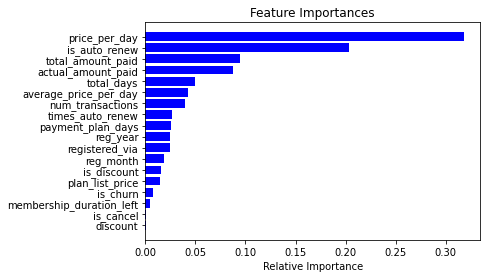

In [ ]:
importances = rfcsearch.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
estimator = rfcsearch.estimators_[5]
# Visualize one tree
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features[1:],
                class_names = ['0', '1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
train_pred = rfcsearch.predict(train.drop(['msno', 'is_churn'], axis=1))
test_pred = rfcsearch.predict(test.drop(['msno', 'is_churn'], axis=1))
print('Train f1 score: ', f1_score(train.is_churn, train_pred))
print('Test f1 score: ', f1_score(test.is_churn, test_pred))

print('Train precision score: ', precision_score(train.is_churn, train_pred))
print('Test precision score: ', precision_score(test.is_churn, test_pred))

print('Train recall score: ', recall_score(train.is_churn, train_pred))
print('Test recall score: ', recall_score(test.is_churn, test_pred))

print('Train accuracy score: ', accuracy_score(train.is_churn, train_pred))
print('Test accuracy score: ', accuracy_score(test.is_churn, test_pred))

Train f1 score:  0.8330091401560311
Test f1 score:  0.7366723189544645
Train precision score:  0.8039037584271931
Test precision score:  0.7066010790225326
Train recall score:  0.8643012152777778
Test recall score:  0.7694168466522678
Train accuracy score:  0.9772447444023895
Test accuracy score:  0.9637069422514578


In [ ]:
train_conf = cm(train.is_churn, train_pred)
test_conf = cm(test.is_churn, test_pred)

In [ ]:
train_conf

array([[645933,   9715],
       [  6253,  39827]])

In [ ]:
test_conf

array([[160160,   3698],
       [  2669,   8906]])

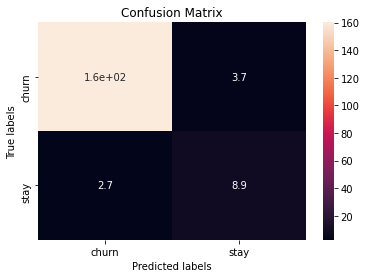

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap([[160.160,   3.698],
       [  2.669,   8.906]], annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['churn', 'stay']); ax.yaxis.set_ticklabels(['churn', 'stay']);
